# Compact architectures
## Audio Classification with the ESC-50 dataset

This notebook performs audio classification on audio fragments of 2 seconds long

In [3]:
# IMPORT ALL LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import seaborn as sns

import librosa
import librosa.display

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

## Load the data

### ESC-50 dataset

In [4]:
# Set sample rate to work with at 8000

SR = 16000

In [5]:
info = pd.read_csv('/kaggle/input/esc50dataset/ESC-50-master/ESC-50-master/meta/esc50.csv')

In [6]:
info_list = list(info['category'].unique())

labels = {}

for i, label in enumerate(info_list):
        labels[label] = i

NUM_CLASSES = len(labels)

In [7]:
# Create a new empty dictionary
reversed_labels = {}

# Iterate through the key-value pairs in the dictionary
for key, value in labels.items():
  # Add the key-value pair to the new dictionary in the reverse order
  reversed_labels[value] = key

In [8]:
esc50_files = list(info['filename'])

### Load the wav files

In [9]:
ESC50_FOLDER = '/kaggle/input/esc50dataset/ESC-50-master/ESC-50-master/audio'

In [10]:
def wav_data_loader(files, normalization=True):
    
    all_fragments = []
    
    for file in files:
        
        # Load the audio file
        
        AUDIO_FILE = os.path.join(ESC50_FOLDER, file)
        
        sample, sample_rate = librosa.load(AUDIO_FILE, sr=SR)
        
        if normalization==True:
            
            # Normalize the waveform
            sample = librosa.util.normalize(sample)
        
        cat = info[info['filename'] == file]['category'].iloc[0]
        
        sample = (sample, labels[cat])    
    
        all_fragments.append(sample)
    
    return all_fragments

In [11]:
%%time
esc50_wav_dataset = wav_data_loader(esc50_files, normalization=False)

CPU times: user 17.9 s, sys: 1.33 s, total: 19.2 s
Wall time: 36.9 s


In [12]:
len(esc50_wav_dataset)

2000

## Train-test split

Creating a first train-test split in the original dataset will be useful for correct data augmentation and pre-processing techniques.

In [13]:
X = [wav[0] for wav in esc50_wav_dataset]
y = [wav[1] for wav in esc50_wav_dataset]

X_train_wav, X_test_wav, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train_wav, X_val_wav, y_train, y_val = train_test_split(X_train_wav, y_train, test_size=0.2, stratify=y_train, random_state=42)

## Waveform augmentation

In [14]:
## Noise addition

def add_noise(wav_data, noise_factor):

    # Generate noise signal with the same shape as input waveform
    noise = np.random.normal(0, 1, len(wav_data))

    # Scale noise signal with the permissible noise factor value
    noise *= noise_factor

    # Add noise signal to input waveform
    augmented_wav_data = wav_data + noise

    # Normalize the augmented waveform data
    augmented_wav_data = librosa.util.normalize(augmented_wav_data)

    return augmented_wav_data

def time_shift(audio, p):
    """
    Shift audio to the left or right by a random amount.
    """
    # Calculate the length of the audio array
    length = audio.shape[0]

    # Calculate the maximum number of samples to shift
    max_shift = int(length * p)

    # Generate a random shift value
    shift = random.randint(-max_shift, max_shift)

    # Create an empty array with the same shape as the audio array
    shifted_audio = np.zeros_like(audio)

    # Shift the audio by the specified number of samples
    if shift > 0:
      # Shift to the right
        shifted_audio[shift:] = audio[:length-shift]
    else:
        # Shift to the left
        shifted_audio[:length+shift] = audio[-shift:]
    
    if np.sum(shifted_audio) == 0:
        #revert the process if all information was erased
        shifted_audio = audio     

    return shifted_audio

def time_stretching(audio,factor):
    
    wav_time_stch = librosa.effects.time_stretch(audio,rate=factor)
    
    return wav_time_stch[:SR*5]

In [15]:
%%time
''' EXUCUTE THIS CELL TO APPLY DATA AUGMENTATION
Lots of memory required this step could be optimized'''

def augment_wavs(wav_dataset, y):
    
    wav_dataset_augmented = []

    for wav in wav_dataset:
        # Create a copy of the original wav to prevent unwanted side effects
        temp_wav = wav.copy()
        temp_wav = add_noise(temp_wav, 0.025) # We want to use values between 0.005 and 0.04
        temp_wav = time_shift(temp_wav, 0.3)  # We want to use a max shift of 30%
        temp_wav = time_stretching(temp_wav, 0.85)

        wav_dataset_augmented.append(temp_wav)

    # Add original wavs to augmented list
    wav_dataset_augmented.extend(wav_dataset)
    
    y = y + y #each spec is being appended at the bottom of the list

    return wav_dataset_augmented, y

X_train_wav, y_train = augment_wavs(X_train_wav, y_train)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


' EXUCUTE THIS CELL TO APPLY DATA AUGMENTATION\nLots of memory required this step could be optimized\n\ndef augment_wavs(wav_dataset, y):\n    \n    wav_dataset_augmented = []\n\n    for wav in wav_dataset:\n        # Create a copy of the original wav to prevent unwanted side effects\n        temp_wav = wav.copy()\n        temp_wav = add_noise(temp_wav, 0.025) # We want to use values between 0.005 and 0.04\n        temp_wav = time_shift(temp_wav, 0.3)  # We want to use a max shift of 30%\n        temp_wav = time_stretching(temp_wav, 0.85)\n\n        wav_dataset_augmented.append(temp_wav)\n\n    # Add original wavs to augmented list\n    wav_dataset_augmented.extend(wav_dataset)\n    \n    y = y + y #each spec is being appended at the bottom of the list\n\n    return wav_dataset_augmented, y\n\nX_train_wav, y_train = augment_wavs(X_train_wav, y_train)\n'

## Split the waveforms

In [16]:
def split_waveforms(X_wav, y, sample_rate=SR, window_size=2, hop_size=0.5):
    
    # Define window size and hop size in samples
    window_size = window_size * sample_rate 
    hop_size = hop_size * sample_rate

    X_segments = []
    y_segments = []

    for i, waveform in enumerate(X_wav):
        for start in np.arange(0, waveform.size - window_size + 1, hop_size):
            end = start + window_size
            segment = waveform[int(start):int(end)]
            X_segments.append(segment)
            y_segments.append(y[i])  # Use the same label for the segment

    return X_segments, y_segments

In [17]:
X_train_wav, y_train = split_waveforms(X_train_wav, y_train)

In [18]:
X_val_wav, y_val = split_waveforms(X_val_wav, y_val)

In [19]:
X_test_wav, y_test = split_waveforms(X_test_wav, y_test)

# Training

## Basic CNN architecture

In [20]:
class LLF(Layer):
    def __init__(self, sample_rate, frame_length, frame_step, num_mel_bins=64, lower_freq=125, upper_freq=7500, log_offset=0.001, **kwargs):
        super(LLF, self).__init__(**kwargs)
        self.sample_rate = sample_rate
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.num_mel_bins = num_mel_bins
        self.lower_freq = lower_freq
        self.upper_freq = upper_freq
        self.log_offset = log_offset

    def call(self, inputs):
        
        # Convert numpy array to Tensor and normalize based on its actual max and min values
        wav = tf.cast(inputs, tf.float32)
        audio_tensor = (wav - tf.math.reduce_min(wav)) / (tf.math.reduce_max(wav) - tf.math.reduce_min(wav)) * 2 - 1
        
        # Compute the Short-Time Fourier Transform (STFT)
        stft = tf.signal.stft(wav, self.frame_length, self.frame_step, window_fn=tf.signal.hann_window)

        # Compute the spectrogram
        spectrogram = tf.abs(stft)

        # Compute the mel-spectrogram
        num_spectrogram_bins = stft.shape[-1]
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            self.num_mel_bins, num_spectrogram_bins, self.sample_rate, self.lower_freq, self.upper_freq)
        mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
        mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

        # Compute the log mel-spectrogram
        log_mel_spectrogram = tf.math.log(mel_spectrogram + self.log_offset)

        # Add a channel dimension
        log_mel_spectrogram = tf.expand_dims(log_mel_spectrogram, -1)

        return log_mel_spectrogram

sample_rate = SR  # Adjust as necessary
window_size_ms = 25
window_hop_ms = 10
frame_length = sample_rate * window_size_ms // 1000
frame_step = sample_rate * window_hop_ms // 1000
AUDIO_LENGTH = 2

class HLFBlock(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(HLFBlock, self).__init__(**kwargs)
        self.seq = Sequential([
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        ])

    def call(self, inputs):
        return self.seq(inputs)

class EmbeddingsBlock(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EmbeddingsBlock, self).__init__(**kwargs)
        self.seq = Sequential([
            tf.keras.layers.Conv2D(256, 1, padding='same', activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.GlobalAveragePooling2D(),
        ])

    def call(self, inputs):
        return self.seq(inputs)
    
HLF = HLFBlock(name='HLF')
Embeddings = EmbeddingsBlock(name='Embeddings')

# Define the model
model = Sequential([
    LLF(sample_rate, frame_length, frame_step, input_shape=(AUDIO_LENGTH*SR,)),
    HLF,
    Embeddings,
    tf.keras.layers.Dense(NUM_CLASSES),
    tf.keras.layers.Activation('softmax')  # The activation should be softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(np.array(X_train_wav), np.array(y_train), epochs=50, batch_size=32, validation_data=(np.array(X_val_wav), np.array(y_val)))

Epoch 1/50


2023-06-11 12:04:35.091292: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/Embeddings/sequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


245/245 [==============================] - 15s 15ms/step - loss: 2.5850 - accuracy: 0.2915 - val_loss: 3.1661 - val_accuracy: 0.1786
Epoch 2/50
245/245 [==============================] - 3s 12ms/step - loss: 1.6707 - accuracy: 0.5172 - val_loss: 1.9998 - val_accuracy: 0.4245
Epoch 3/50
245/245 [==============================] - 3s 12ms/step - loss: 1.2478 - accuracy: 0.6443 - val_loss: 1.6793 - val_accuracy: 0.4913
Epoch 4/50
245/245 [==============================] - 3s 12ms/step - loss: 0.9996 - accuracy: 0.7147 - val_loss: 1.6700 - val_accuracy: 0.5464
Epoch 5/50
245/245 [==============================] - 3s 11ms/step - loss: 0.8037 - accuracy: 0.7747 - val_loss: 1.6402 - val_accuracy: 0.5633
Epoch 6/50
245/245 [==============================] - 3s 12ms/step - loss: 0.6964 - accuracy: 0.8004 - val_loss: 2.1830 - val_accuracy: 0.4862
Epoch 7/50
245/245 [==============================] - 3s 12ms/step - loss: 0.5881 - accuracy: 0.8325 - val_loss: 1.9148 - val_accuracy: 0.5510
Epoch 8/5

In [21]:
# Performance Evaluation
test_loss, test_accuracy = model.evaluate(np.array(X_test_wav), np.array(y_test), verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

132/132 - 1s - loss: 2.7678 - accuracy: 0.6217 - 811ms/epoch - 6ms/step
Test loss: 2.767807722091675
Test accuracy: 0.621666669845581


In [22]:
# Computational complexity evaluation
total_params = model.count_params()
print(f'Total parameters: {total_params}')

Total parameters: 139442


In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 llf (LLF)                   (None, 198, 64, 1)        0         
                                                                 
 HLF (HLFBlock)              (None, 12, 4, 128)        93568     
                                                                 
 Embeddings (EmbeddingsBlock  (None, 256)              33024     
 )                                                               
                                                                 
 dense (Dense)               (None, 50)                12850     
                                                                 
 activation (Activation)     (None, 50)                0         
                                                                 
Total params: 139,442
Trainable params: 138,994
Non-trainable params: 448
______________________________________________

### Visualization of the training process

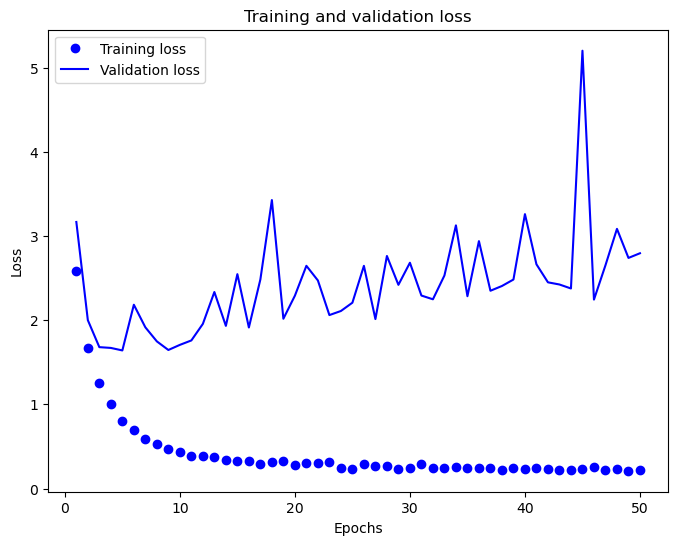

In [24]:
# Plot the loss curves for training and validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

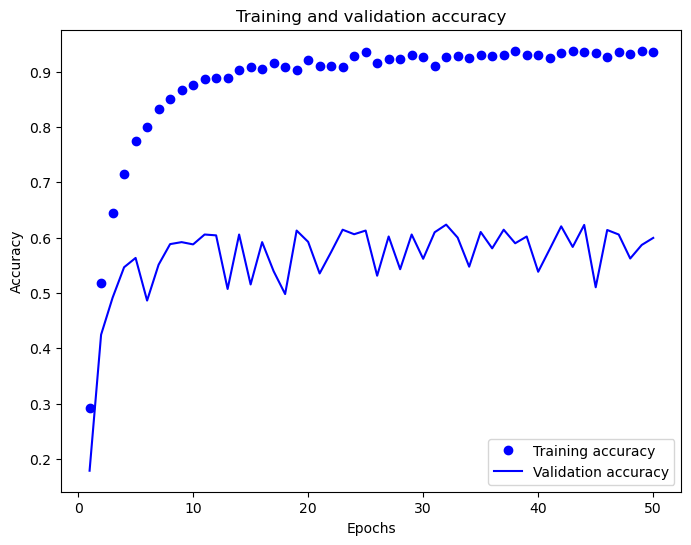

In [25]:
# Plot the accuracy curves for training and validation.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
# Save and export the model

model.save('model_esc50_basic_al2s.h5')

### Confusion matrix

132/132 [==============================] - 1s 5ms/step


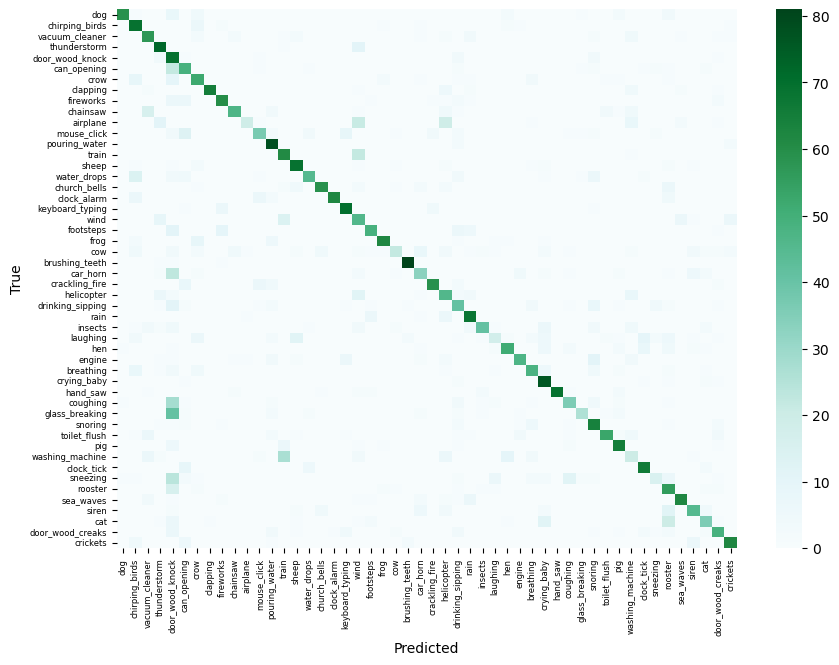

In [27]:
y_true = y_test
y_pred = model.predict(np.array(X_test_wav))
y_pred = np.argmax(y_pred, axis=1)

# Get the class names in the order corresponding to the class indices
class_names = [reversed_labels[i] for i in range(len(reversed_labels))]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Visualize the ouput of the LLF

In [28]:
idx = 55
sample = X_test_wav[idx]
sample = sample.reshape(1, AUDIO_LENGTH * SR) # Add a batch dimension

1/1 [==============================] - 0s 289ms/step


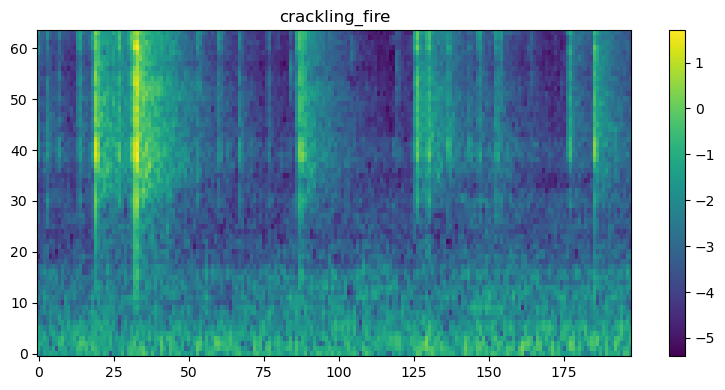

In [29]:
# Get the output of the SpectrogramLayer
spectrogram_model = Model(inputs=model.inputs, outputs=model.get_layer(index=0).output)
spectrogram_output = spectrogram_model.predict(sample)

# Create a figure with custom size (e.g., width=10 inches, height=6 inches)
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title(reversed_labels[y_test[idx]])
spectrogram = spectrogram_output.squeeze().T  # Transpose the spectrogram and remove redundant dimensions

img = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
fig.colorbar(img, ax=ax)

plt.tight_layout()
plt.show()

## Depthwise Spearable Convolutions

In [30]:
class LLF(Layer):
    def __init__(self, sample_rate, frame_length, frame_step, num_mel_bins=64, lower_freq=125, upper_freq=7500, log_offset=0.001, **kwargs):
        super(LLF, self).__init__(**kwargs)
        self.sample_rate = sample_rate
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.num_mel_bins = num_mel_bins
        self.lower_freq = lower_freq
        self.upper_freq = upper_freq
        self.log_offset = log_offset

    def call(self, inputs):
        
        # Convert numpy array to Tensor and normalize based on its actual max and min values
        wav = tf.cast(inputs, tf.float32)
        audio_tensor = (wav - tf.math.reduce_min(wav)) / (tf.math.reduce_max(wav) - tf.math.reduce_min(wav)) * 2 - 1
        
        # Compute the Short-Time Fourier Transform (STFT)
        stft = tf.signal.stft(wav, self.frame_length, self.frame_step, window_fn=tf.signal.hann_window)

        # Compute the spectrogram
        spectrogram = tf.abs(stft)

        # Compute the mel-spectrogram
        num_spectrogram_bins = stft.shape[-1]
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            self.num_mel_bins, num_spectrogram_bins, self.sample_rate, self.lower_freq, self.upper_freq)
        mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
        mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

        # Compute the log mel-spectrogram
        log_mel_spectrogram = tf.math.log(mel_spectrogram + self.log_offset)

        # Add a channel dimension
        log_mel_spectrogram = tf.expand_dims(log_mel_spectrogram, -1)

        return log_mel_spectrogram

sample_rate = SR  # Adjust as necessary
window_size_ms = 25
window_hop_ms = 10
frame_length = sample_rate * window_size_ms // 1000
frame_step = sample_rate * window_hop_ms // 1000
AUDIO_LENGTH = 2

class HLFBlock(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(HLFBlock, self).__init__(**kwargs)
        self.seq = Sequential([
            tf.keras.layers.SeparableConv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.SeparableConv2D(64, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.SeparableConv2D(128, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        ])

    def call(self, inputs):
        return self.seq(inputs)

class EmbeddingsBlock(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EmbeddingsBlock, self).__init__(**kwargs)
        self.seq = Sequential([
            tf.keras.layers.Conv2D(256, 1, padding='same', activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.GlobalAveragePooling2D(),
        ])

    def call(self, inputs):
        return self.seq(inputs)
    
HLF = HLFBlock(name='HLF')
Embeddings = EmbeddingsBlock(name='Embeddings')

# Define the model
model = Sequential([
    LLF(sample_rate, frame_length, frame_step, input_shape=(AUDIO_LENGTH*SR,)),
    HLF,
    Embeddings,
    tf.keras.layers.Dense(NUM_CLASSES),
    tf.keras.layers.Activation('softmax')  # The activation should be softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(np.array(X_train_wav), np.array(y_train), epochs=50, batch_size=32, validation_data=(np.array(X_val_wav), np.array(y_val)))

Epoch 1/50


2023-06-11 12:07:16.905314: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/Embeddings/sequential_4/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


245/245 [==============================] - 8s 16ms/step - loss: 2.8893 - accuracy: 0.2163 - val_loss: 3.7721 - val_accuracy: 0.0408
Epoch 2/50
245/245 [==============================] - 3s 10ms/step - loss: 2.0672 - accuracy: 0.4110 - val_loss: 2.4614 - val_accuracy: 0.3291
Epoch 3/50
245/245 [==============================] - 3s 10ms/step - loss: 1.6672 - accuracy: 0.5247 - val_loss: 1.8484 - val_accuracy: 0.4837
Epoch 4/50
245/245 [==============================] - 3s 12ms/step - loss: 1.4018 - accuracy: 0.5898 - val_loss: 1.8665 - val_accuracy: 0.4832
Epoch 5/50
245/245 [==============================] - 3s 12ms/step - loss: 1.2092 - accuracy: 0.6490 - val_loss: 1.8666 - val_accuracy: 0.5031
Epoch 6/50
245/245 [==============================] - 3s 11ms/step - loss: 1.0479 - accuracy: 0.6977 - val_loss: 1.7323 - val_accuracy: 0.5276
Epoch 7/50
245/245 [==============================] - 3s 13ms/step - loss: 0.9228 - accuracy: 0.7314 - val_loss: 1.9407 - val_accuracy: 0.5102
Epoch 8/50

In [31]:
# Performance Evaluation
test_loss, test_accuracy = model.evaluate(np.array(X_test_wav), np.array(y_test), verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

132/132 - 1s - loss: 3.0404 - accuracy: 0.5810 - 701ms/epoch - 5ms/step
Test loss: 3.0403733253479004
Test accuracy: 0.5809524059295654


In [32]:
# Computational complexity evaluation
total_params = model.count_params()
print(f'Total parameters: {total_params}')

Total parameters: 58139


In [33]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 llf_1 (LLF)                 (None, 198, 64, 1)        0         
                                                                 
 HLF (HLFBlock)              (None, 12, 4, 128)        12265     
                                                                 
 Embeddings (EmbeddingsBlock  (None, 256)              33024     
 )                                                               
                                                                 
 dense_1 (Dense)             (None, 50)                12850     
                                                                 
 activation_1 (Activation)   (None, 50)                0         
                                                                 
Total params: 58,139
Trainable params: 57,691
Non-trainable params: 448
________________________________________________

### Visualization of the training process

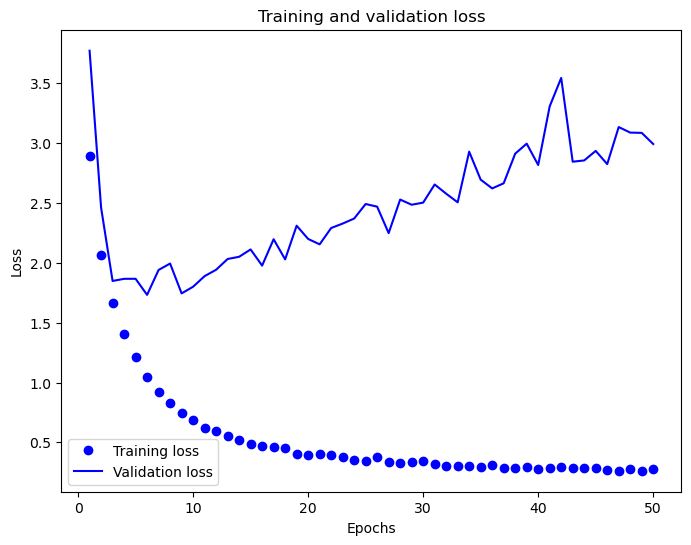

In [34]:
# Plot the loss curves for training and validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

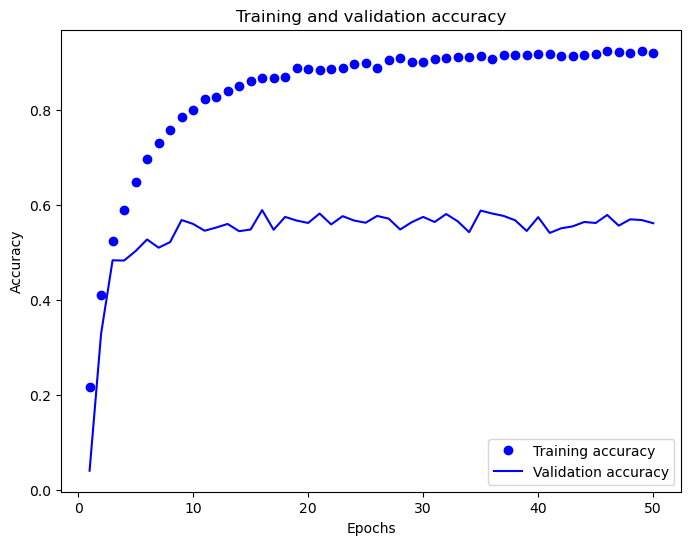

In [35]:
# Plot the accuracy curves for training and validation.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [36]:
# Save and export the model

model.save('model_esc50_dw_al2s.h5')

### Confusion matrix

132/132 [==============================] - 1s 5ms/step


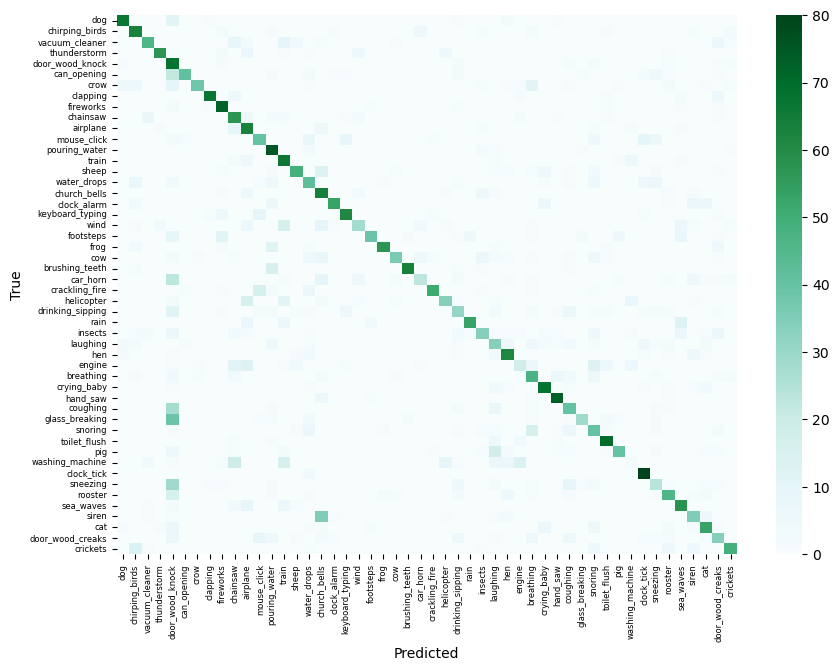

In [37]:
y_true = y_test
y_pred = model.predict(np.array(X_test_wav))
y_pred = np.argmax(y_pred, axis=1)

# Get the class names in the order corresponding to the class indices
class_names = [reversed_labels[i] for i in range(len(reversed_labels))]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Visualize the ouput of the LLF

In [38]:
idx = 55
sample = X_test_wav[idx]
sample = sample.reshape(1, AUDIO_LENGTH * SR) # Add a batch dimension

1/1 [==============================] - 0s 313ms/step


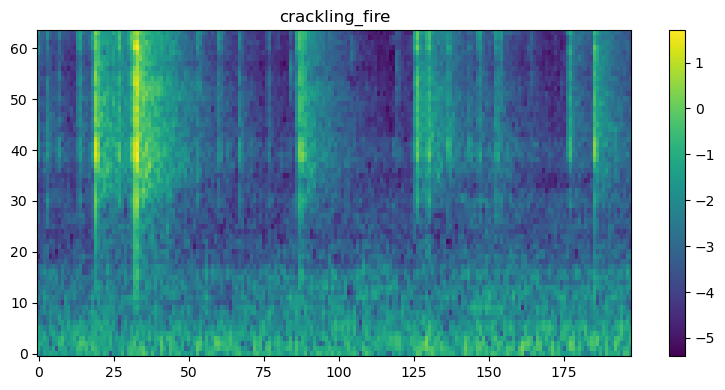

In [39]:
# Get the output of the SpectrogramLayer
spectrogram_model = Model(inputs=model.inputs, outputs=model.get_layer(index=0).output)
spectrogram_output = spectrogram_model.predict(sample)

# Create a figure with custom size (e.g., width=10 inches, height=6 inches)
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title(reversed_labels[y_test[idx]])
spectrogram = spectrogram_output.squeeze().T  # Transpose the spectrogram and remove redundant dimensions

img = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
fig.colorbar(img, ax=ax)

plt.tight_layout()
plt.show()

## Transfer Learning with Mobilenet_v1

## Mobilenet_v1 with randomly initialized weights


In [47]:
# Load the MobileNetV1 model but exclude the top layers
mobilenet_model = MobileNet(weights=None, include_top=False, input_shape=(198, 64, 3))

class LLF_3channels(Layer):
    def __init__(self, sample_rate, frame_length, frame_step, num_mel_bins=64, lower_freq=125, upper_freq=7500, log_offset=0.001, **kwargs):
        super(LLF_3channels, self).__init__(**kwargs)
        self.sample_rate = sample_rate
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.num_mel_bins = num_mel_bins
        self.lower_freq = lower_freq
        self.upper_freq = upper_freq
        self.log_offset = log_offset

    def call(self, inputs):
        
        # Convert numpy array to Tensor and normalize based on its actual max and min values
        wav = tf.cast(inputs, tf.float32)
        audio_tensor = (wav - tf.math.reduce_min(wav)) / (tf.math.reduce_max(wav) - tf.math.reduce_min(wav)) * 2 - 1
        
        # Compute the Short-Time Fourier Transform (STFT)
        stft = tf.signal.stft(wav, self.frame_length, self.frame_step, window_fn=tf.signal.hann_window)

        # Compute the spectrogram
        spectrogram = tf.abs(stft)

        # Compute the mel-spectrogram
        num_spectrogram_bins = stft.shape[-1]
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            self.num_mel_bins, num_spectrogram_bins, self.sample_rate, self.lower_freq, self.upper_freq)
        mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
        mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

        # Compute the log mel-spectrogram
        log_mel_spectrogram = tf.math.log(mel_spectrogram + self.log_offset)

        # Add a channel dimension
        log_mel_spectrogram = tf.expand_dims(log_mel_spectrogram, -1)
        
        # Convert 1-channel image to 3-channel image
        x = tf.repeat(log_mel_spectrogram, 3, axis=-1)
        
        return x

sample_rate = 16000  # Adjust as necessary
window_size_ms = 25
window_hop_ms = 10
frame_length = sample_rate * window_size_ms // 1000
frame_step = sample_rate * window_hop_ms // 1000
audio_length = sample_rate*2

class MobileNetEmbeddings(Model):
    def __init__(self, base_model, **kwargs):
        super(MobileNetEmbeddings, self).__init__(**kwargs)
        self.base_model = base_model
        self.pooling = GlobalAveragePooling2D()
        
    def call(self, inputs):
        x = self.base_model(inputs)
        return self.pooling(x)

MobileNet_embeddings = MobileNetEmbeddings(mobilenet_model, name="MobileNet_embeddings")

# Define the model
model = Sequential([
    LLF_3channels(sample_rate=sample_rate, frame_length=frame_length, frame_step=frame_step, input_shape=(audio_length,)),
    MobileNet_embeddings,
    tf.keras.layers.Dense(NUM_CLASSES),
    tf.keras.layers.Activation('softmax')
])

for layer in mobilenet_model.layers:
    layer.trainable = True

# Define a learning rate
learning_rate = 0.001/2 # With low learning rates the model gets stuck at local minumums that cause overfitting.
                        # With high learning rates the performance is inconsistent

# Initialize the Adam optimizer with the lower learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
earlystopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

# Define model checkpoint
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)

callbacks = [earlystopping, model_checkpoint]

# Train the model
history = model.fit(np.array(X_train_wav), np.array(y_train), epochs=50, batch_size=32, 
                    validation_data=(np.array(X_val_wav), np.array(y_val)),
                    callbacks=callbacks)

Epoch 1/50
245/245 [==============================] - ETA: 0s - loss: 3.2829 - accuracy: 0.1246
Epoch 1: val_loss improved from inf to 4.54986, saving model to best_model.h5
245/245 [==============================] - 27s 46ms/step - loss: 3.2829 - accuracy: 0.1246 - val_loss: 4.5499 - val_accuracy: 0.0214
Epoch 2/50
245/245 [==============================] - ETA: 0s - loss: 2.4114 - accuracy: 0.3005
Epoch 2: val_loss did not improve from 4.54986
245/245 [==============================] - 9s 38ms/step - loss: 2.4114 - accuracy: 0.3005 - val_loss: 5.0968 - val_accuracy: 0.0179
Epoch 3/50
244/245 [============================>.] - ETA: 0s - loss: 1.8877 - accuracy: 0.4433
Epoch 3: val_loss improved from 4.54986 to 3.59002, saving model to best_model.h5
245/245 [==============================] - 10s 42ms/step - loss: 1.8858 - accuracy: 0.4437 - val_loss: 3.5900 - val_accuracy: 0.1449
Epoch 4/50
245/245 [==============================] - ETA: 0s - loss: 1.4678 - accuracy: 0.5663
Epoch 4: va

In [55]:
model.load_weights('best_model.h5')

In [56]:
# Performance Evaluation
test_loss, test_accuracy = model.evaluate(np.array(X_test_wav), np.array(y_test), verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

132/132 - 2s - loss: 2.4709 - accuracy: 0.5445 - 2s/epoch - 13ms/step
Test loss: 2.470878839492798
Test accuracy: 0.5445238351821899


In [53]:
# Computational complexity evaluation
total_params = model.count_params()
print(f'Total parameters: {total_params}')

Total parameters: 3280114


In [54]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 llf_3channels_5 (LLF_3chann  (None, 198, 64, 3)       0         
 els)                                                            
                                                                 
 MobileNet_embeddings (Mobil  (None, 1024)             3228864   
 eNetEmbeddings)                                                 
                                                                 
 dense_8 (Dense)             (None, 50)                51250     
                                                                 
 activation_7 (Activation)   (None, 50)                0         
                                                                 
Total params: 3,280,114
Trainable params: 3,258,226
Non-trainable params: 21,888
_________________________________________________________________


### Visualization of the training process

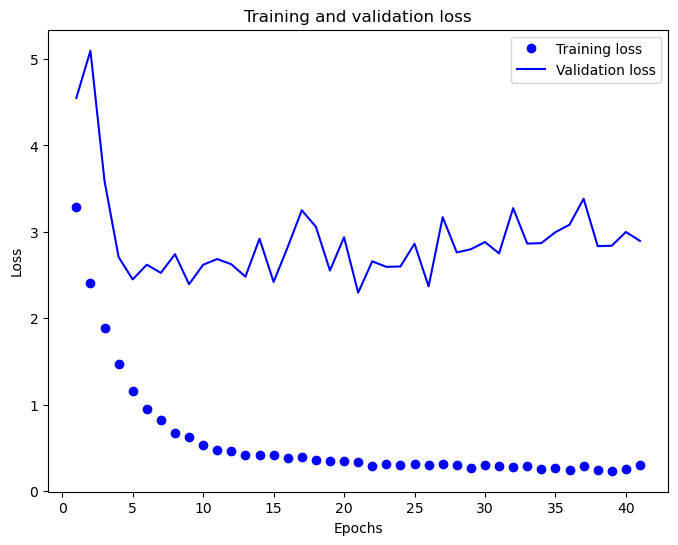

In [57]:
# Plot the loss curves for training and validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

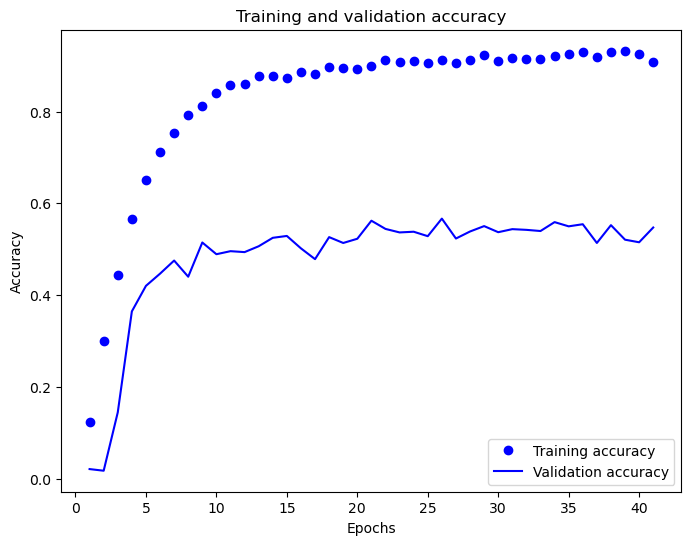

In [58]:
# Plot the accuracy curves for training and validation.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [59]:
# Save and export the model

model.save('model_esc50_mobilenet_random_al2s.h5')

### Confusion matrix

132/132 [==============================] - 2s 12ms/step


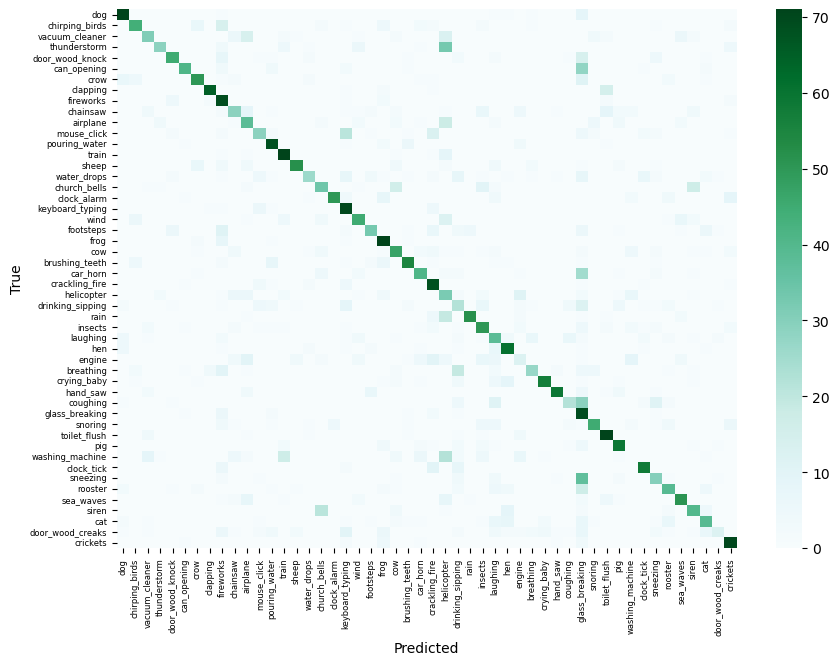

In [60]:
y_true = y_test
y_pred = model.predict(np.array(X_test_wav))
y_pred = np.argmax(y_pred, axis=1)

# Get the class names in the order corresponding to the class indices
class_names = [reversed_labels[i] for i in range(len(reversed_labels))]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Transfer learning with Imagenet


In [62]:
# Load the MobileNetV1 model but exclude the top layers
mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(198, 64, 3))

class LLF_3channels(Layer):
    def __init__(self, sample_rate, frame_length, frame_step, num_mel_bins=64, lower_freq=125, upper_freq=7500, log_offset=0.001, **kwargs):
        super(LLF_3channels, self).__init__(**kwargs)
        self.sample_rate = sample_rate
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.num_mel_bins = num_mel_bins
        self.lower_freq = lower_freq
        self.upper_freq = upper_freq
        self.log_offset = log_offset

    def call(self, inputs):
        
        # Convert numpy array to Tensor and normalize based on its actual max and min values
        wav = tf.cast(inputs, tf.float32)
        audio_tensor = (wav - tf.math.reduce_min(wav)) / (tf.math.reduce_max(wav) - tf.math.reduce_min(wav)) * 2 - 1
        
        # Compute the Short-Time Fourier Transform (STFT)
        stft = tf.signal.stft(wav, self.frame_length, self.frame_step, window_fn=tf.signal.hann_window)

        # Compute the spectrogram
        spectrogram = tf.abs(stft)

        # Compute the mel-spectrogram
        num_spectrogram_bins = stft.shape[-1]
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            self.num_mel_bins, num_spectrogram_bins, self.sample_rate, self.lower_freq, self.upper_freq)
        mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
        mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

        # Compute the log mel-spectrogram
        log_mel_spectrogram = tf.math.log(mel_spectrogram + self.log_offset)

        # Add a channel dimension
        log_mel_spectrogram = tf.expand_dims(log_mel_spectrogram, -1)
        
        # Convert 1-channel image to 3-channel image
        x = tf.repeat(log_mel_spectrogram, 3, axis=-1)
        
        return x

sample_rate = 16000  # Adjust as necessary
window_size_ms = 25
window_hop_ms = 10
frame_length = sample_rate * window_size_ms // 1000
frame_step = sample_rate * window_hop_ms // 1000
audio_length = sample_rate*2

class MobileNetEmbeddings(Model):
    def __init__(self, base_model, **kwargs):
        super(MobileNetEmbeddings, self).__init__(**kwargs)
        self.base_model = base_model
        self.pooling = GlobalAveragePooling2D()
        
    def call(self, inputs):
        x = self.base_model(inputs)
        return self.pooling(x)

MobileNet_embeddings = MobileNetEmbeddings(mobilenet_model, name="MobileNet_embeddings")

# Define the model
model = Sequential([
    LLF_3channels(sample_rate=sample_rate, frame_length=frame_length, frame_step=frame_step, input_shape=(audio_length,)),
    MobileNet_embeddings,
    tf.keras.layers.Dense(NUM_CLASSES),
    tf.keras.layers.Activation('softmax')
])

for layer in mobilenet_model.layers[:20]: #The first 20 layers of the model are frozen
    layer.trainable = False

# Define a learning rate
learning_rate = 0.001/2 # With low learning rates the model gets stuck at local minumums that cause overfitting.
                        # With high learning rates the performance is inconsistent

# Initialize the Adam optimizer with the lower learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
earlystopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

# Define model checkpoint
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)

callbacks = [earlystopping, model_checkpoint]

# Train the model
history = model.fit(np.array(X_train_wav), np.array(y_train), epochs=50, batch_size=32, 
                    validation_data=(np.array(X_val_wav), np.array(y_val)),
                    callbacks=callbacks)

Epoch 1/50
245/245 [==============================] - ETA: 0s - loss: 1.4439 - accuracy: 0.6149
Epoch 1: val_loss improved from inf to 2.06263, saving model to best_model.h5
245/245 [==============================] - 22s 39ms/step - loss: 1.4439 - accuracy: 0.6149 - val_loss: 2.0626 - val_accuracy: 0.5301
Epoch 2/50
245/245 [==============================] - ETA: 0s - loss: 0.5110 - accuracy: 0.8529
Epoch 2: val_loss improved from 2.06263 to 1.83232, saving model to best_model.h5
245/245 [==============================] - 7s 30ms/step - loss: 0.5110 - accuracy: 0.8529 - val_loss: 1.8323 - val_accuracy: 0.5898
Epoch 3/50
245/245 [==============================] - ETA: 0s - loss: 0.3879 - accuracy: 0.8890
Epoch 3: val_loss did not improve from 1.83232
245/245 [==============================] - 7s 30ms/step - loss: 0.3879 - accuracy: 0.8890 - val_loss: 1.8424 - val_accuracy: 0.6005
Epoch 4/50
245/245 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.9043
Epoch 4: val

In [63]:
model.load_weights('best_model.h5')

In [64]:
# Performance Evaluation
test_loss, test_accuracy = model.evaluate(np.array(X_test_wav), np.array(y_test), verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

132/132 - 2s - loss: 1.8499 - accuracy: 0.6369 - 2s/epoch - 12ms/step
Test loss: 1.8498598337173462
Test accuracy: 0.636904776096344


In [65]:
# Computational complexity evaluation
total_params = model.count_params()
print(f'Total parameters: {total_params}')

Total parameters: 3280114


In [66]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 llf_3channels_7 (LLF_3chann  (None, 198, 64, 3)       0         
 els)                                                            
                                                                 
 MobileNet_embeddings (Mobil  (None, 1024)             3228864   
 eNetEmbeddings)                                                 
                                                                 
 dense_10 (Dense)            (None, 50)                51250     
                                                                 
 activation_9 (Activation)   (None, 50)                0         
                                                                 
Total params: 3,280,114
Trainable params: 3,244,210
Non-trainable params: 35,904
_________________________________________________________________


### Visualization of the training process

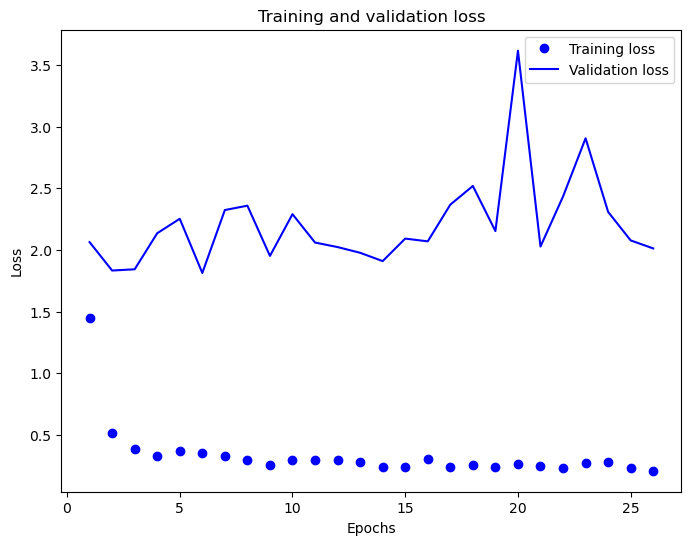

In [67]:
# Plot the loss curves for training and validation.

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

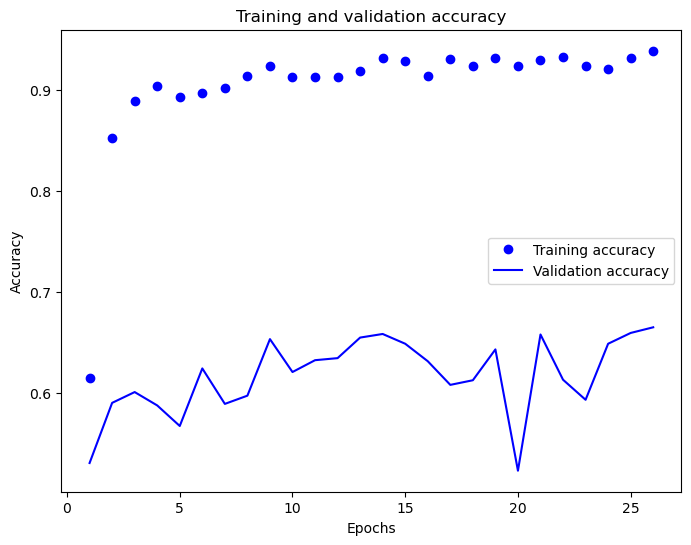

In [68]:
# Plot the accuracy curves for training and validation.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [69]:
# Save and export the model

model.save('model_esc50_mobilenet_imagenet_al2s.h5')

### Confusion matrix

132/132 [==============================] - 2s 11ms/step


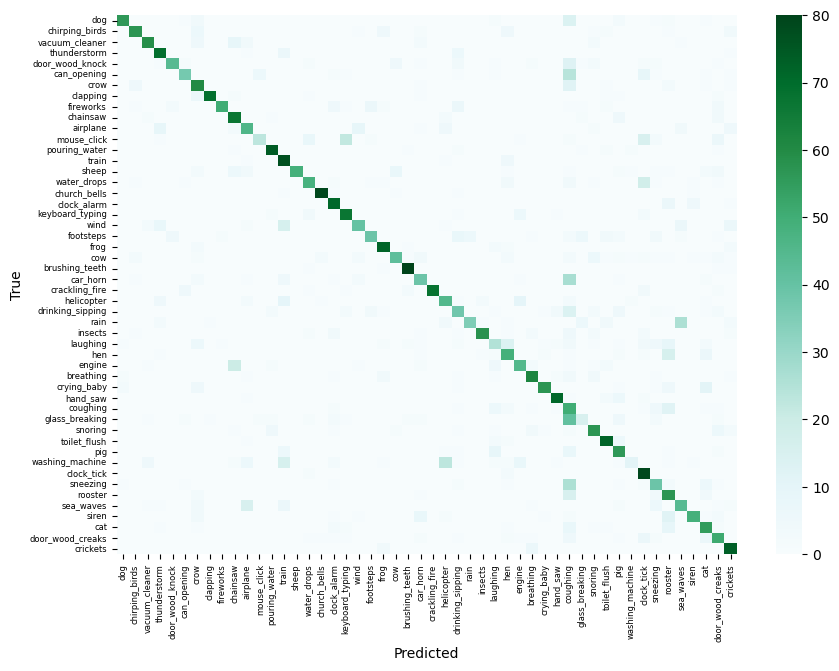

In [70]:
y_true = y_test
y_pred = model.predict(np.array(X_test_wav))
y_pred = np.argmax(y_pred, axis=1)

# Get the class names in the order corresponding to the class indices
class_names = [reversed_labels[i] for i in range(len(reversed_labels))]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()